In [1]:
import numpy as np
import ctypes
from scipy import stats
import os
import time

def cpvalcomp(geno, expr):
    _path = os.path.dirname('.')
    clib = np.ctypeslib.load_library('../lib/linear_regression.so', _path)
    cfstat = clib.fit
    cfstat.restype = ctypes.c_int
    cfstat.argtypes = [np.ctypeslib.ndpointer(ctypes.c_double, ndim=1, flags='C_CONTIGUOUS, ALIGNED'),
                       np.ctypeslib.ndpointer(ctypes.c_double, ndim=1, flags='C_CONTIGUOUS, ALIGNED'),
                       ctypes.c_int,
                       ctypes.c_int,
                       ctypes.c_int,
                       np.ctypeslib.ndpointer(ctypes.c_double, ndim=1, flags='C_CONTIGUOUS, ALIGNED')
                      ]

    x = geno.reshape(-1,)
    y = expr.reshape(-1,)
    xsize = x.shape[0]
    nsnps = geno.shape[0]
    nsample = geno.shape[1]
    ngene = expr.shape[0]
    fstat = np.zeros(nsnps * ngene)
    success = cfstat(x, y, nsnps, ngene, nsample, fstat)
    pvals = 1 - stats.f.cdf(fstat, 1, nsample-2)
    pvals = pvals.reshape(nsnps, ngene)
    #qscores = np.array([qstat.qscore(pvals[i,:]) for i in range(nsnps)])
    #pqvals  = np.array([qstat.p_qscore(qscores[i], qcal) for i in range(nsnps)])
    #gene_indices = list()
    #for snp in range(nsnps):
    #    if pqvals[snp] < 0.05:
    #        gene_indices.append(np.where(pvals[snp, :] < 0.05)[0])
    #    else:
    #        gene_indices.append(np.array([], dtype=int))
    return fstat, pvals #, qscores, pqvals#, gene_indices

In [2]:
n = 1000 # no. of samples
m = 10000 # no. of genes

genotype = np.random.rand(n).reshape(1, n) # only 1 genotype
expression = np.random.rand(n * m).reshape(m, n)

In [3]:
fstat, pvals = cpvalcomp(genotype, expression)

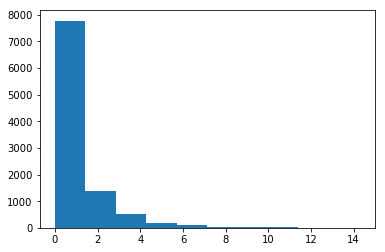

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(fstat)

plt.show()

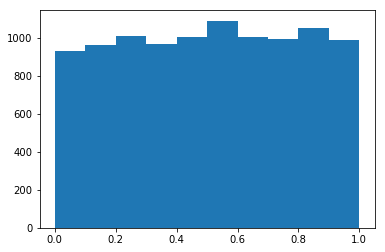

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(pvals.reshape(-1,))

plt.show()

In [6]:
np.where(fstat > 10)

(array([   4,  355,  678,  732,  987,  990,  992, 1575, 1613, 1888, 2069,
        2438, 3130, 4055, 5631, 6330, 7669, 7840, 8210, 8275, 8466, 8507,
        8702]),)

In [9]:
np.where(pvals.reshape(-1) < 0.001)

(array([ 355,  990,  992, 1888, 2069, 3130, 6330, 7669, 7840, 8210, 8466,
        8507, 8702]),)

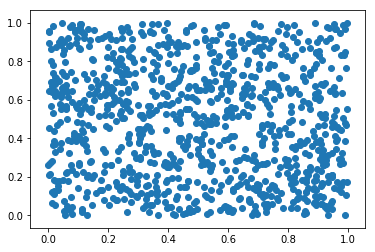

In [10]:
Y = expression[355, :]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(genotype, Y)

plt.show()

In [14]:
X = genotype.T
Y = expression[355, :].T.reshape(-1, 1)

from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
model.coef_
sse = np.sum((model.predict(X) - Y) ** 2) / (n - 1)
se = np.sqrt(sse * (1 / np.dot(X.T, X)))
t = model.coef_ / se
p = 2 * (1 - stats.t.cdf(np.abs(t), Y.shape[0] - X.shape[1]))

In [16]:
p

array([[  1.05317532e-10]])

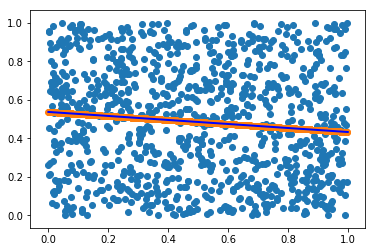

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X, Y)
ax1.plot([0, 1], model.intercept_ + [0, model.coef_], lw = 2, color='blue')
ax1.scatter(X, model.predict(X))
plt.show()

In [ ]:
np.where( abs(model.predict(X) - Y) > 0.4 )

In [ ]:
from sklearn import linear_model
from scipy import stats

pvals = np.zeros(m)
for i in range(m):
    model = linear_model.LinearRegression()
    X = genoty[:, i].reshape(-1, 1)
    Y = response
    model.fit(X, Y)
    sse = np.sum((model.predict(X) - Y) ** 2) / (n - 1)
    se = np.sqrt(sse * (1 / np.dot(X.T, X)))
    t = model.coef_ / se
    p = 2 * (1 - stats.t.cdf(np.abs(t), Y.shape[0] - X.shape[1]))
    pvals[i] = p